In [1]:
pip install -q numpy pandas matplotlib seaborn scikit-learn joblib xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 1
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

OUT = "output"
FIGS = os.path.join(OUT, "figs")
MODELS = "models"
os.makedirs(FIGS, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)
print("Folders:", OUT, FIGS, MODELS)


Folders: output output\figs models


In [3]:
# Cell 2 - loader (expects mushrooms.csv inside ./data or root)
import glob

DATA_DIR = "data"
candidates = ["mushrooms.csv", "mushroom.csv", "Mushrooms.csv"]

found = None
for name in candidates:
    p = os.path.join(DATA_DIR, name)
    if os.path.exists(p):
        found = p
        break

# fallback: any csv in data/
if found is None and os.path.isdir(DATA_DIR):
    csvs = glob.glob(os.path.join(DATA_DIR, "*.csv"))
    if csvs:
        found = csvs[0]

if found is None:
    raise FileNotFoundError("No mushrooms CSV found in ./data. Put mushrooms.csv into data/ and rerun.")

print("Loading:", found)
df = pd.read_csv(found)
print("Shape:", df.shape)
df.head()


Loading: data\mushrooms.csv
Shape: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Columns: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

Value counts of target:
 class
e    4208
p    3916
Name: count, dtype: int64


,count,unique,top,freq
class,8124,2,e,4208
cap-shape,8124,6,x,3656
cap-surface,8124,4,y,3244
cap-color,8124,10,n,2284
bruises,8124,2,f,4748
odor,8124,9,n,3528
gill-attachment,8124,2,f,7914
gill-spacing,8124,2,c,6812
gill-size,8124,2,b,5612
gill-color,8124,12,b,1728


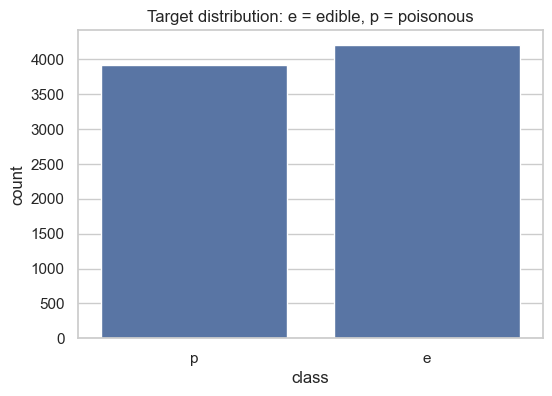

In [4]:
# Cell 3
print("Columns:", df.columns.tolist())
print("\nValue counts of target:\n", df['class'].value_counts())
display(df.describe(include='all').T)

plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df)
plt.title("Target distribution: e = edible, p = poisonous")
plt.savefig(os.path.join(FIGS, "target_dist.png"), bbox_inches="tight")
plt.show()


In [5]:
# Cell 4
# target 'class' is 'e' or 'p' (if different name, adjust)
target_col = 'class'
if target_col not in df.columns:
    # try alternatives
    possible = [c for c in df.columns if c.lower() in ('class','type','label','target')]
    if possible:
        target_col = possible[0]
    else:
        raise ValueError("Target column not found.")

# encode target
le = LabelEncoder()
y = le.fit_transform(df[target_col])  # e->0, p->1 usually
print("Label classes:", le.classes_)

# drop target and create features
X_raw = df.drop(columns=[target_col])
print("All features are categorical? dtypes:", X_raw.dtypes.unique())

# one-hot encode categorical features using pandas
X = pd.get_dummies(X_raw, drop_first=True)  # drop_first reduces col count
print("After one-hot shape:", X.shape)


Label classes: ['e' 'p']
All features are categorical? dtypes: [dtype('O')]
After one-hot shape: (8124, 95)


In [6]:
# Cell 5
# compute feature importances later; here show top 10 value counts for a few categorical features
print("Example top unique values per feature:")
for c in X_raw.columns[:6]:
    print(c, ":", X_raw[c].unique()[:10])


Example top unique values per feature:
cap-shape : ['x' 'b' 's' 'f' 'k' 'c']
cap-surface : ['s' 'y' 'f' 'g']
cap-color : ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises : ['t' 'f']
odor : ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment : ['f' 'a']


In [7]:
# Cell 6
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (6499, 95) Test shape: (1625, 95)


In [8]:
# Cell 7
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', random_state=42)
}

fitted = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    acc = accuracy_score(y_test, preds)
    fitted[name] = (m, acc)
    print(f"{name:18s} Test Accuracy: {acc:.4f}")


RandomForest       Test Accuracy: 1.0000
LogisticRegression Test Accuracy: 0.9988
XGBoost            Test Accuracy: 1.0000
SVM                Test Accuracy: 1.0000


In [9]:
# Cell 8
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, (model, _) in fitted.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name:18s} CV mean={scores.mean():.4f} std={scores.std():.4f}")


RandomForest       CV mean=1.0000 std=0.0000
LogisticRegression CV mean=0.9996 std=0.0005
XGBoost            CV mean=1.0000 std=0.0000
SVM                CV mean=1.0000 std=0.0000


Best model: RandomForest acc: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



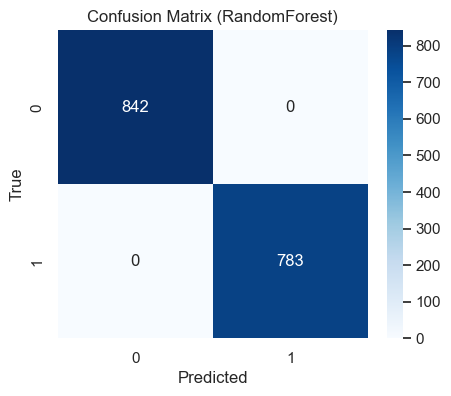

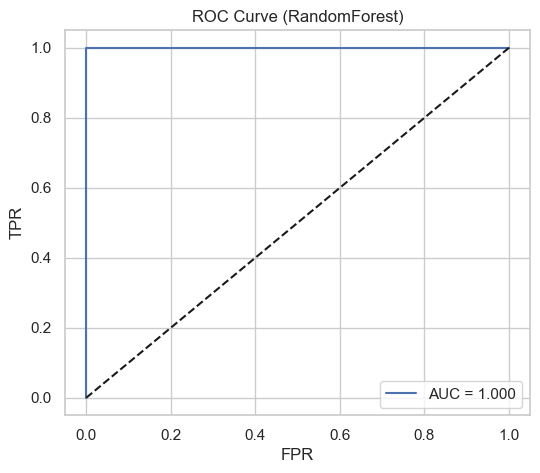

In [10]:
# Cell 9
best_name = max(fitted.items(), key=lambda kv: kv[1][1])[0]
best_model = fitted[best_name][0]
best_acc = fitted[best_name][1]
print("Best model:", best_name, "acc:", best_acc)

# preds & proba
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title(f"Confusion Matrix ({best_name})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(FIGS, f"confusion_matrix_{best_name}.png"), bbox_inches='tight')
plt.show()

# ROC if possible
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC Curve ({best_name})")
    plt.legend()
    plt.savefig(os.path.join(FIGS, f"roc_{best_name}.png"), bbox_inches='tight')
    plt.show()
else:
    print("No probability available for ROC.")


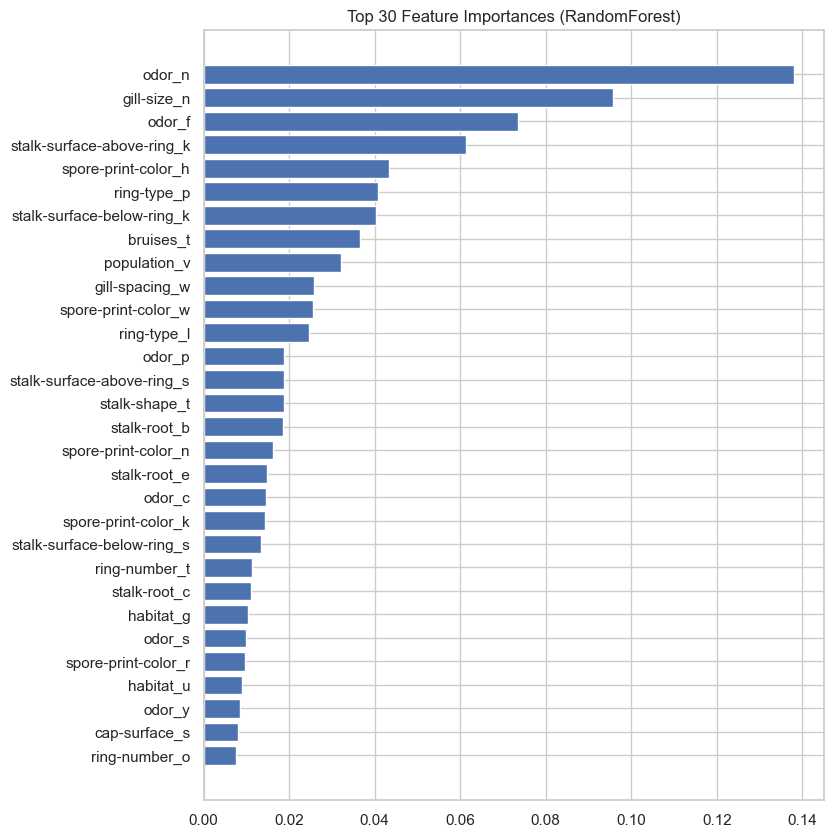

In [11]:
# Cell 10
features = X.columns
plt.figure(figsize=(8,10))
if best_name in ("RandomForest",):
    imp = best_model.feature_importances_
    idx = np.argsort(imp)[-30:]  # top 30
    plt.barh(range(len(idx)), imp[idx])
    plt.yticks(range(len(idx)), [features[i] for i in idx])
    plt.title("Top 30 Feature Importances (RandomForest)")
    plt.savefig(os.path.join(FIGS, "feature_importances_rf.png"), bbox_inches='tight')
    plt.show()
elif best_name == "XGBoost":
    imp = best_model.feature_importances_
    idx = np.argsort(imp)[-30:]
    plt.barh(range(len(idx)), imp[idx])
    plt.yticks(range(len(idx)), [features[i] for i in idx])
    plt.title("Top 30 Feature Importances (XGBoost)")
    plt.savefig(os.path.join(FIGS, "feature_importances_xgb.png"), bbox_inches='tight')
    plt.show()
else:
    print("Feature importance not available for", best_name, "- consider using RandomForest or XGBoost.")


In [12]:
# Cell 11
save_path = os.path.join(MODELS, f"best_mushroom_model_{best_name}.joblib")
joblib.dump({"name": best_name, "model": best_model, "encoder": None, "features": list(X.columns)}, save_path)
print("Saved model to:", save_path)


Saved model to: models\best_mushroom_model_RandomForest.joblib


In [13]:
# Cell 12
report = f"""
Mushroom Classification Report
Best model: {best_name}
Test accuracy: {best_acc:.4f}
"""
open(os.path.join(OUT, "report.txt"), "w").write(report.strip())
print(report)



Mushroom Classification Report
Best model: RandomForest
Test accuracy: 1.0000

